In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
from scipy.interpolate import CubicSpline
from itertools import product
from sklearn.metrics import r2_score
import csv
from vmd import VMD

In [2]:
# adjusted R-squared
def r2_score_adjusted(y, y_pred, featurecount):
    n = len(y)
    return 1 - (1-r2_score(y, y_pred)) * (n-1)/(n-featurecount-1)

# AIC
def calculate_aic(y, y_pred, k):
    sse = np.sum((y - y_pred) ** 2)
    n = len(y)
    aic = n * np.log(sse / n) + 2 * k
    return aic

# BIC
def calculate_bic(y, y_pred, k):
    sse = np.sum((y - y_pred) ** 2)
    n = len(y)
    bic = n * np.log(sse / n) + k * np.log(n)
    return bic

# импорт временного ряда

In [3]:
seasonsTS = ("s9",)
# trendsTS = ("t7")
# noisesTS = ("n21")

cases = ("t7_n21_s7", "t7_n21_s7_s9", "t7_n21_s8", "t7_n21_s8_s9")

In [4]:
# Trend = list()
# t = pd.read_csv(f".\Components\\{trendsTS}.csv", decimal=',')
# trend = pd.DataFrame(t, dtype=float)
# Trend = trend["Value"]

# Noise = list()
# n = pd.read_csv(f".\Components\\{noisesTS}.csv", decimal=',')
# noise = pd.DataFrame(n, dtype=float)
# Noise = noise["Value"]

Season = list()
s7 = pd.read_csv(f".\Components\\s7.csv", decimal=',')
season7 = pd.DataFrame(s7, dtype=float)
Season.append(season7['Value'])
for season_i in seasonsTS:
    s = pd.read_csv(f".\Components\\{season_i}.csv", decimal=',')
    season = pd.DataFrame(s, dtype=float)
    Season.append(season7['Value']+season['Value'])

s8 = pd.read_csv(f".\Components\\s8.csv", decimal=',')
season8 = pd.DataFrame(s8, dtype=float)
Season.append(season8['Value'])
for season_i in seasonsTS:
    s = pd.read_csv(f".\Components\\{season_i}.csv", decimal=',')
    season = pd.DataFrame(s, dtype=float)
    Season.append(season8['Value']+season['Value'])

In [5]:
index = list()
TS = list()

data = pd.read_csv(f".\Cases\\{cases[0]}.csv", decimal=',')
df = pd.DataFrame(data, dtype=float)
index = df.index

for case_i in cases:
    data = pd.read_csv(f".\Cases\\{case_i}.csv", decimal=',')
    df = pd.DataFrame(data, dtype=float)
    TS.append(df.values)


# тестовый анализ

In [7]:
alpha = 1000
init = 1
DC = True
K = 5
tau = 0            #BY DEFAULT  
tol = 1e-6         #BY DEFAULT

u, u_hat, omega = VMD(TS[0], alpha, tau, K, DC, init, tol)

featurecount = 6

Text(0.5, 0, 'X')

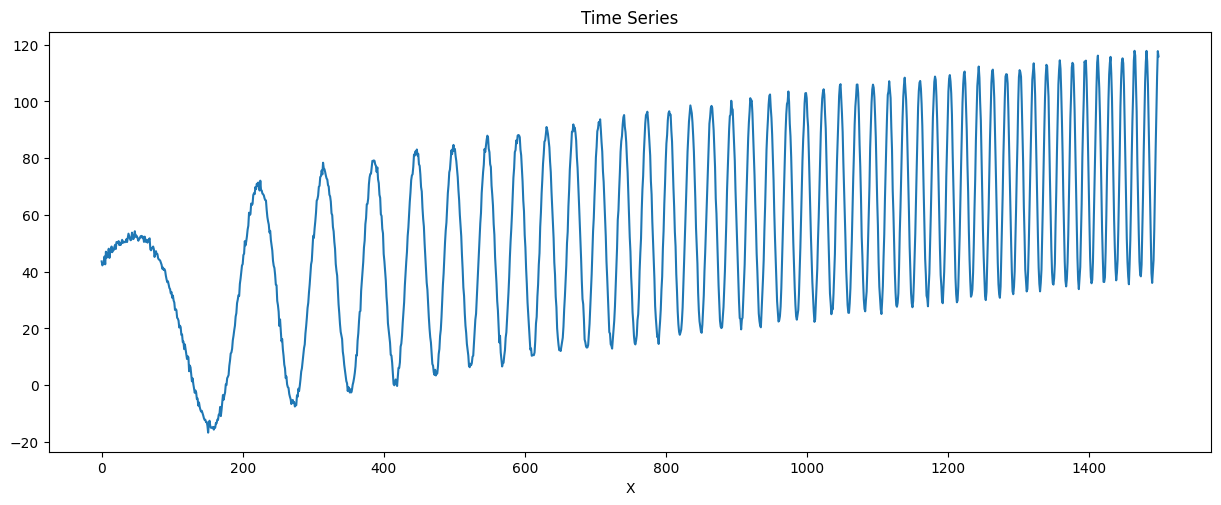

In [8]:
plt.figure(figsize=(15,12))
plt.subplot(2,1,1)
plt.plot(index[0], TS[0])
plt.title('Time Series')
plt.xlabel('X')

Text(0.5, 0, 'X')

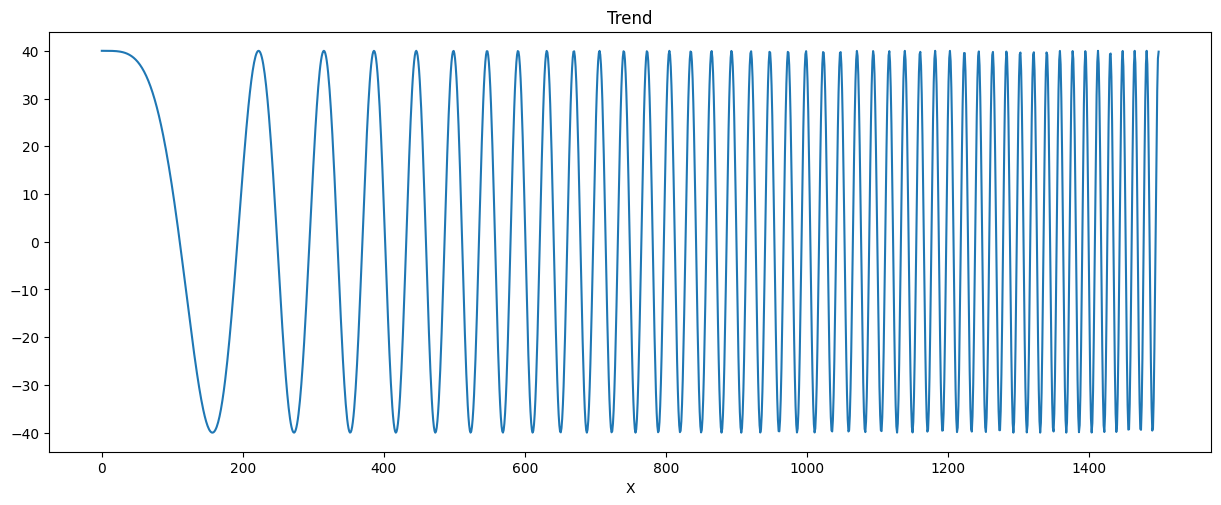

In [9]:
plt.figure(figsize=(15,12))
plt.subplot(2,1,1)
plt.plot(index[0], Season)
plt.title('Trend')
plt.xlabel('X')

In [32]:
sum_of_imfs = 0
i_imfs = K-2
for j in range(1, i_imfs+1):
    sum_of_imfs += u[j].T

In [34]:
r2_score(Season, sum_of_imfs)

0.8663624537396057

Text(0.5, 0, 'X')

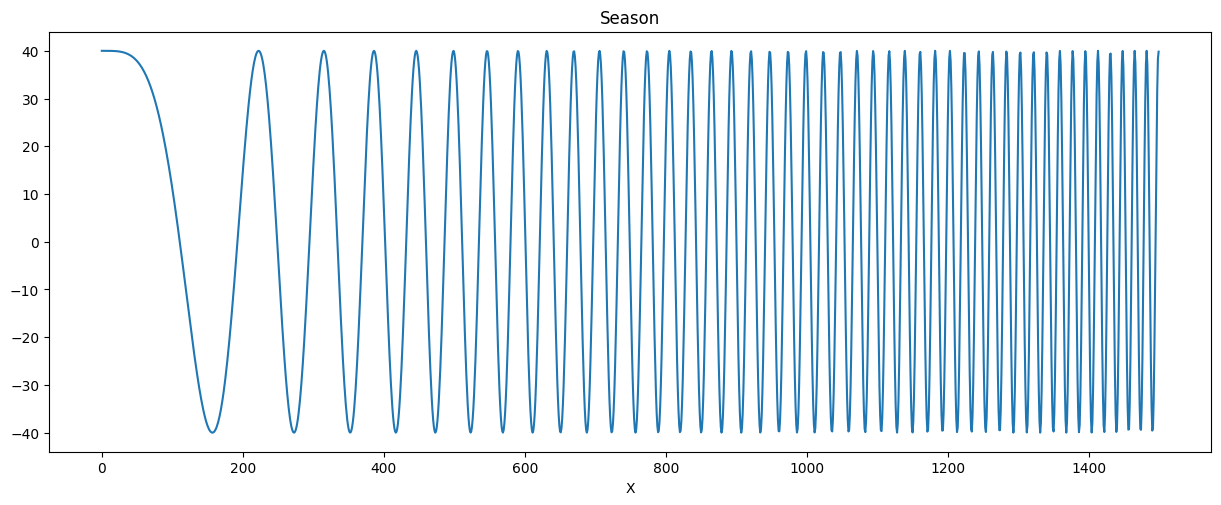

In [22]:
plt.figure(figsize=(15,12))
plt.subplot(2,1,1)
plt.plot(index[0], Season)
plt.title('Season')
plt.xlabel('X')

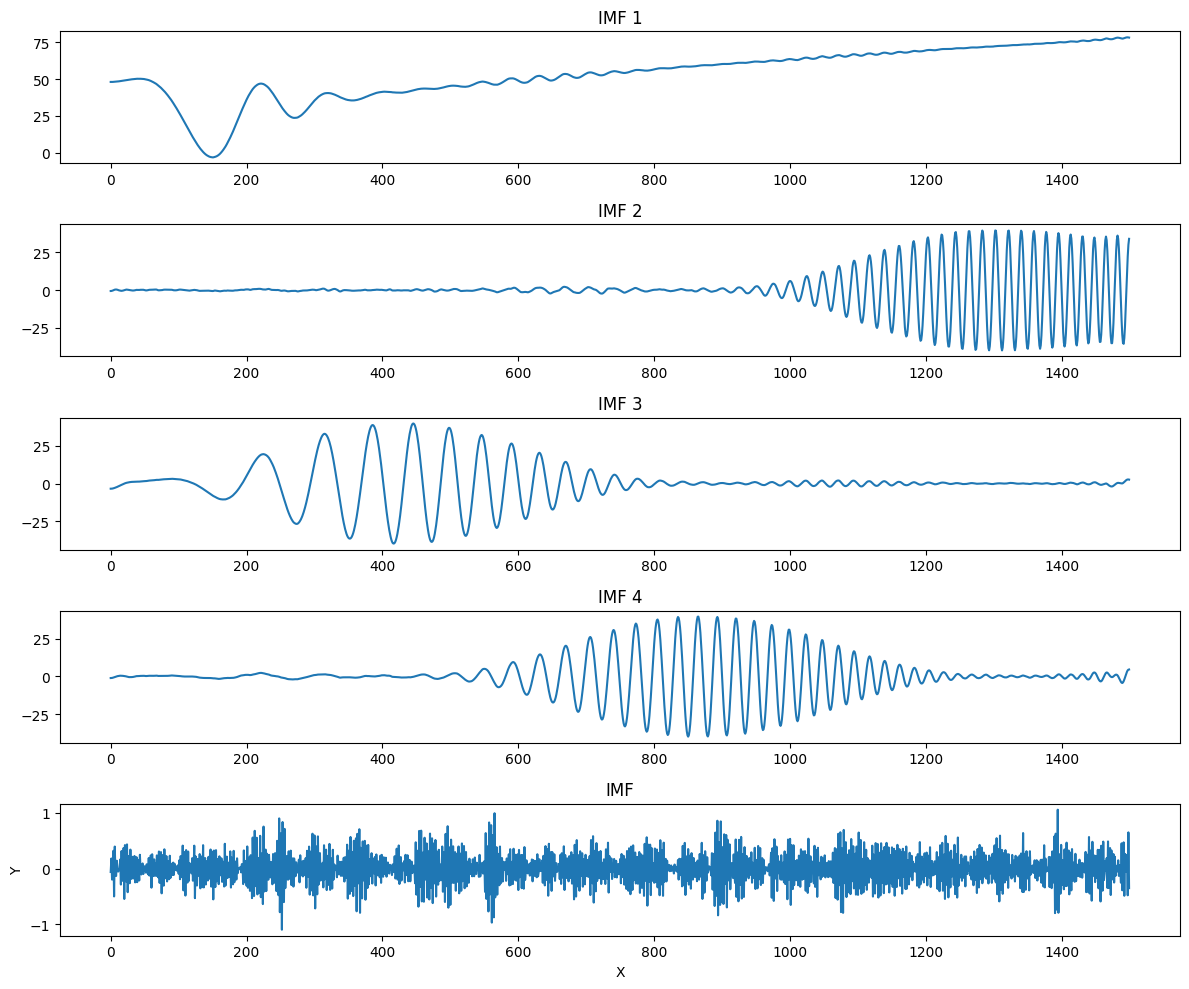

In [101]:
# plt.figure(figsize=(15,12))
# plt.subplot(2,1,1)
# plt.plot(index[0], TS[0])

fig, axs = plt.subplots(figsize=(12,10), nrows=K)

# axs[0].set(xlabel = 'date', ylabel='C')
# plt.subplot(2,2,1)
for i in range(K):
    axs[i].plot(index[0], u[i].T)
    axs[i].set_title(f'IMF {i+1}')

plt.title('IMF')
plt.xlabel('X')
plt.ylabel('Y')
# plt.legend(['Оригинальный сигнал', 'Нижняя огибающая', 'Верхняя огибающая', 'Средняя огибающих'])

plt.tight_layout()

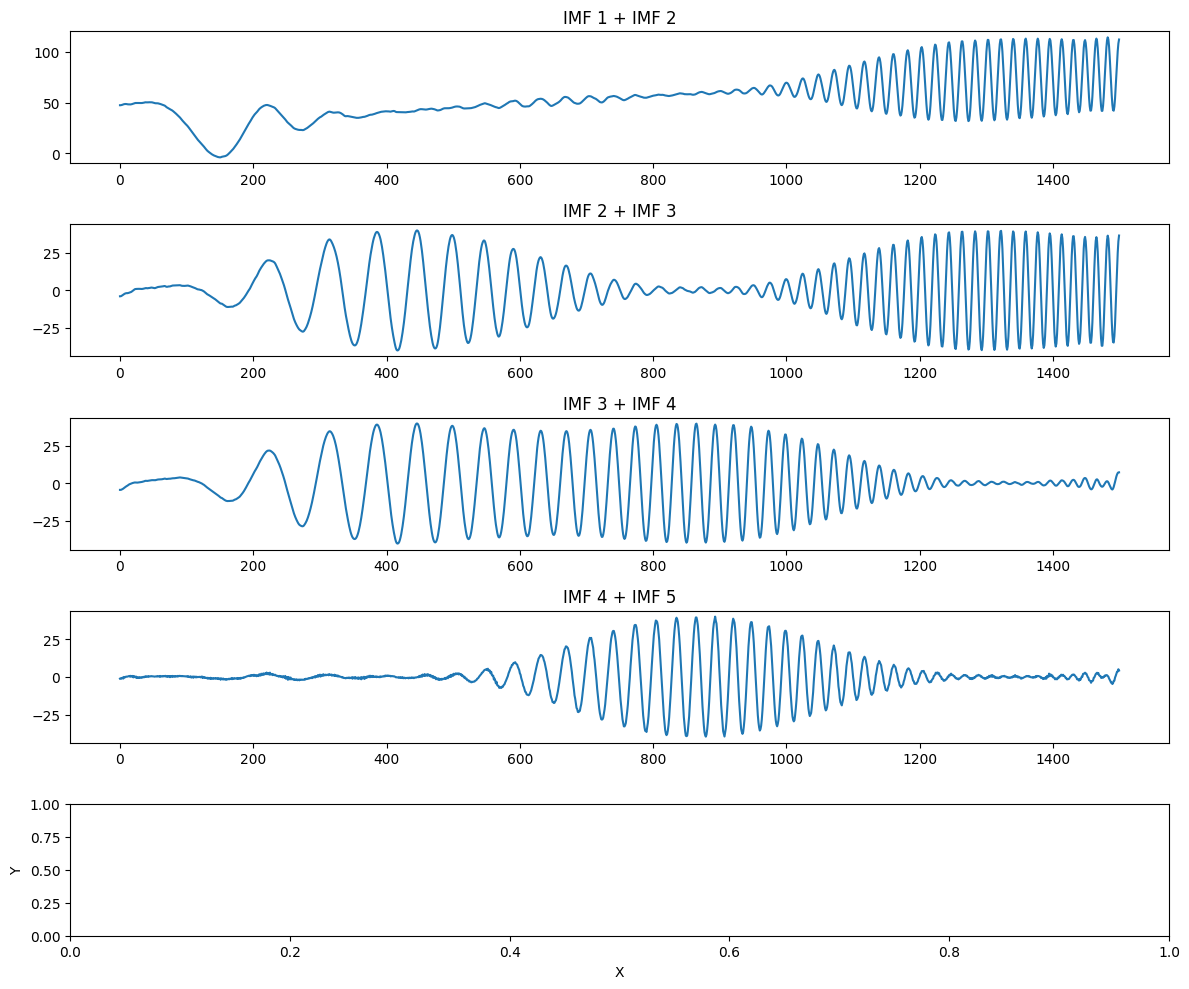

In [104]:
# plt.figure(figsize=(15,12))
# plt.subplot(2,1,1)
# plt.plot(index[0], TS[0])

fig, axs = plt.subplots(figsize=(12,10), nrows=K)

# axs[0].set(xlabel = 'date', ylabel='C')
# plt.subplot(2,2,1)
for i in range((K-1)):
    axs[i].plot(index[0], u[i].T + u[i+1].T)
    axs[i].set_title(f'IMF {i+1} + IMF {i+2}')

# plt.title('IMF')
plt.xlabel('X')
plt.ylabel('Y')
# plt.legend(['Оригинальный сигнал', 'Нижняя огибающая', 'Верхняя огибающая', 'Средняя огибающих'])

plt.tight_layout()

# декомпозиция временного ряда

In [8]:
alpha = (0, 500, 1000, 5000, 10000, 20000)
init = (0, 1, 2)
DC = (False, True)
K = (3, 5, 7)
params_set = list(product(alpha, K, DC, init))

tau = 0            #BY DEFAULT  
tol = 1e-6         #BY DEFAULT

featurecount = 6

In [9]:
best_metriks = np.zeros(len(TS), dtype=dict)

best_r2_params = np.zeros(len(TS), dtype=dict)
best_r2_adj_params = np.zeros(len(TS), dtype=dict)
best_aic_params = np.zeros(len(TS), dtype=dict)
best_bic_params = np.zeros(len(TS), dtype=dict)

for i in range(len(TS)):
    best_metriks[i] = {"Time Series": f"TS{i+1}", "R2": -np.inf, "R2_Adj": -np.inf, "AIC" : np.inf, "BIC": np.inf}
    
    best_r2_params[i] = ({"Time Series": f"TS{i+1}", "Metric": "R2", "alpha": 0, "tau": tau, "K": 3, "DC": False, "init": 0, "tol": tol, "IMFs" : "1"}) 
    best_r2_adj_params[i] = ({"Time Series": f"TS{i+1}", "Metric": "R2_Adj", "alpha": 0, "tau": tau, "K": 3, "DC": False, "init": 0, "tol": tol, "IMFs" : "1"}) 
    best_aic_params[i] = ({"Time Series": f"TS{i+1}", "Metric": "AIC", "alpha": 0, "tau": tau, "K": 3, "DC": False, "init": 0, "tol": tol, "IMFs" : "1"}) 
    best_bic_params[i] = ({"Time Series": f"TS{i+1}", "Metric": "BIC", "alpha": 0, "tau": tau, "K": 3, "DC": False, "init": 0, "tol": tol, "IMFs" : "1"}) 


In [10]:
# для всех лчм
for ts_i in range(len(TS)):

    j=0
    r2_list = np.zeros((len(params_set), 2), dtype=float)
    r2_adj_list = np.zeros((len(params_set), 2), dtype=float)
    aic_list = np.zeros((len(params_set), 2), dtype=float)
    bic_list = np.zeros((len(params_set), 2), dtype=float)
    # для всех наборов параметров
    for params_i in params_set:
        u, u_hat, omega = VMD(TS[ts_i], params_i[0], tau, params_i[1], params_i[2], params_i[3], tol)
        
        k_i = params_i[1]
        r2 = list()
        r2_adj = list()
        aic = list()
        bic = list()
        sum_of_imfs = 0
        for i_imfs in range(1, k_i):
            sum_of_imfs += u[i_imfs].T

            r2.append(r2_score(Season[ts_i], sum_of_imfs))
            r2_adj.append(r2_score_adjusted(Season[ts_i], sum_of_imfs, featurecount))
            aic.append(calculate_aic(Season[ts_i], sum_of_imfs, featurecount))
            bic.append(calculate_bic(Season[ts_i], sum_of_imfs, featurecount))

        r2_list[j] = [np.max(r2), np.argmax(r2)]
        r2_adj_list[j] = [np.max(r2_adj), np.argmax(r2_adj)]
        aic_list[j] = [np.min(aic), np.argmin(aic)]
        bic_list[j] = [np.min(bic), np.argmin(bic)]

        j+=1

    r2_list = np.transpose(r2_list)
    max_r2 = np.max(r2_list[0])
    argmax_r2 = np.argmax(r2_list[0])
    i_imfs = int(r2_list[1][argmax_r2])
    if (max_r2 > best_metriks[ts_i]["R2"]):
        best_metriks[ts_i]["R2"] = max_r2

        best_r2_params[ts_i]["alpha"] = params_set[argmax_r2][0]
        best_r2_params[ts_i]["K"] = params_set[argmax_r2][1]
        best_r2_params[ts_i]["DC"] = params_set[argmax_r2][2]
        best_r2_params[ts_i]["init"] = params_set[argmax_r2][3]
        best_r2_params[ts_i]["IMFs"] = f'2 - {i_imfs+1}'

    r2_adj_list = np.transpose(r2_adj_list)
    max_r2_adj = np.max(r2_adj_list[0])
    argmax_r2_adj = np.argmax(r2_adj_list[0])
    i_imfs = int(r2_adj_list[1][argmax_r2_adj])
    if (max_r2_adj > best_metriks[ts_i]["R2_Adj"]):
        best_metriks[ts_i]["R2_Adj"] = max_r2_adj

        best_r2_adj_params[ts_i]["alpha"] = params_set[argmax_r2_adj][0]
        best_r2_adj_params[ts_i]["K"] = params_set[argmax_r2_adj][1]
        best_r2_adj_params[ts_i]["DC"] = params_set[argmax_r2_adj][2]
        best_r2_adj_params[ts_i]["init"] = params_set[argmax_r2_adj][3]
        best_r2_adj_params[ts_i]["IMFs"] = f'2 - {i_imfs+1}'

    aic_list = np.transpose(aic_list)
    min_aic = np.min(aic_list[0])
    argmin_aic = np.argmin(aic_list[0])
    i_imfs = int(aic_list[1][argmin_aic])
    if (min_aic < best_metriks[ts_i]["AIC"]):
        best_metriks[ts_i]["AIC"] = min_aic

        best_aic_params[ts_i]["alpha"] = params_set[argmin_aic][0]
        best_aic_params[ts_i]["K"] = params_set[argmin_aic][1]
        best_aic_params[ts_i]["DC"] = params_set[argmin_aic][2]
        best_aic_params[ts_i]["init"] = params_set[argmin_aic][3]
        best_aic_params[ts_i]["IMFs"] = f'2 - {i_imfs+1}'

    bic_list = np.transpose(bic_list)
    min_bic = np.min(bic_list[0])
    argmin_bic = np.argmin(bic_list[0])
    i_imfs = int(bic_list[1][argmin_bic])
    if (min_bic < best_metriks[ts_i]["BIC"]):
        best_metriks[ts_i]["BIC"] = min_bic

        best_bic_params[ts_i]["alpha"] = params_set[argmin_bic][0]
        best_bic_params[ts_i]["K"] = params_set[argmin_bic][1]
        best_bic_params[ts_i]["DC"] = params_set[argmin_bic][2]
        best_bic_params[ts_i]["init"] = params_set[argmin_bic][3]
        best_bic_params[ts_i]["IMFs"] = f'2 - {i_imfs+1}'


c:\Users\George\VS Code Projects\TS Generator\про периодики с непостоянными амплитудами\vmd.py:67: RuntimeWarning: invalid value encountered in scalar divide
  return np.dot(freqs[T//2:T],(abs(u_hat_plus[n+1, T//2:T, k])**2))/np.sum(abs(u_hat_plus[n+1,T//2:T,k])**2)
c:\Users\George\VS Code Projects\TS Generator\про периодики с непостоянными амплитудами\vmd.py:64: RuntimeWarning: invalid value encountered in divide
  return (f_hat_plus - sum_uk - lambda_hat[n,:]/2)/(1.+Alpha[k]*(freqs - omega_plus[n,k])**2)
c:\Users\George\VS Code Projects\TS Generator\про периодики с непостоянными амплитудами\vmd.py:67: RuntimeWarning: invalid value encountered in scalar divide
  return np.dot(freqs[T//2:T],(abs(u_hat_plus[n+1, T//2:T, k])**2))/np.sum(abs(u_hat_plus[n+1,T//2:T,k])**2)
c:\Users\George\VS Code Projects\TS Generator\про периодики с непостоянными амплитудами\vmd.py:64: RuntimeWarning: invalid value encountered in divide
  return (f_hat_plus - sum_uk - lambda_hat[n,:]/2)/(1.+Alpha[k]*(freqs

# метрики точности и параметры с выводом

In [11]:
filename=".\Output\\Best_Metriks-Season.csv"

fields = best_metriks[0].keys()
fields = list(fields)

with open(filename, mode='w', newline='') as file:
    writer = csv.DictWriter(file, fieldnames=fields)
    writer.writeheader()  # Write header row
    for ts_i in range(len(TS)):
        writer.writerows([best_metriks[ts_i]])  # Write data rows

In [12]:
filename=".\Output\\Parameters-Season.csv"

fields = best_r2_params[0].keys()
fields = list(fields)

with open(filename, mode='w', newline='') as file:
    writer = csv.DictWriter(file, fieldnames=fields)
    writer.writeheader()  # Write header row
    for ts_i in range(len(TS)):
        writer.writerows([best_r2_params[ts_i]])  # Write data rows
        writer.writerows([best_r2_adj_params[ts_i]])  # Write data rows
        writer.writerows([best_aic_params[ts_i]])  # Write data rows
        writer.writerows([best_bic_params[ts_i]])  # Write data rows

